# Task4 建模与调参
## 学习内容包括：逻辑回归模型， 树模型， 集成模型（基于bagging, 基于boosting思想的模型-XGBoost,LightGBM,CatBoost）

首先对比模型，以及模型的性能评估。
### <p>逻辑回归：

<li>优点
    
训练速度较快，分类的时候，计算量仅仅只和特征的数目相关；
    
简单易理解，模型的可解释性非常好，从特征的权重可以看到不同的特征对最后结果的影响；
    
适合二分类问题，不需要缩放输入特征；
    
内存资源占用小，只需要存储各个维度的特征值；
</li>
<li>缺点

逻辑回归需要预先处理缺失值和异常值【可参考task3特征工程】；

不能用Logistic回归去解决非线性问题，因为Logistic的决策面是线性的；

对多重共线性数据较为敏感，且很难处理数据不平衡的问题；

准确率并不是很高，因为形式非常简单，很难去拟合数据的真实分布；
 </li>
    
### <p>决策树模型
    
<li>优点
    
简单直观，生成的决策树可以可视化展示
    
数据不需要预处理，不需要归一化，不需要处理缺失数据
    
既可以处理离散值，也可以处理连续值
<li>缺点
    
决策树算法非常容易过拟合，导致泛化能力不强（可进行适当的剪枝）
    
采用的是贪心算法，容易得到局部最优解
    
    
    
### 集成模型集成方法（ensemble method）
通过组合多个学习器来完成学习任务，通过集成方法，可以将多个弱学习器组合成一个强分类器，因此集成学习的泛化能力一般比单一分类器要好。

集成方法主要包括Bagging和Boosting，Bagging和Boosting都是将已有的分类或回归算法通过一定方式组合起来，形成一个更加强大的分类。两种方法都是把若干个分类器整合为一个分类器的方法，只是整合的方式不一样，最终得到不一样的效果。常见的基于Baggin思想的集成模型有：随机森林、基于Boosting思想的集成模型有：Adaboost、GBDT、XgBoost、LightGBM等。

### Baggin和Boosting的区别总结如下：

<li>样本选择上： Bagging方法的训练集是从原始集中有放回的选取，所以从原始集中选出的各轮训练集之间是独立的；而Boosting方法需要每一轮的训练集不变，只是训练集中每个样本在分类器中的权重发生变化。而权值是根据上一轮的分类结果进行调整

<li>样例权重上： Bagging方法使用均匀取样，所以每个样本的权重相等；而Boosting方法根据错误率不断调整样本的权值，错误率越大则权重越大
    
<li>预测函数上： Bagging方法中所有预测函数的权重相等；而Boosting方法中每个弱分类器都有相应的权重，对于分类误差小的分类器会有更大的权重
    
<li>并行计算上： Bagging方法中各个预测函数可以并行生成；而Boosting方法各个预测函数只能顺序生成，因为后一个模型参数需要前一轮模型的结果。


In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\matplotlib\

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
# 读取数据
data_train = pd.read_csv('../train.csv')
data_test = pd.read_csv('../testA.csv')

data_train = reduce_mem_usage(data_train)
data_test = reduce_mem_usage(data_test)

Memory usage of dataframe is 300800128.00 MB
Memory usage after optimization is: 72834944.00 MB
Decreased by 75.8%
Memory usage of dataframe is 73600128.00 MB
Memory usage after optimization is: 18034520.00 MB
Decreased by 75.5%


In [12]:
data_train['isDefault']

0         1
1         0
2         0
3         0
4         0
         ..
799995    0
799996    0
799997    1
799998    0
799999    0
Name: isDefault, Length: 800000, dtype: int8

In [13]:
#采用 Kfold 方法进行建模， K设置为5

from sklearn.model_selection import KFold

# 分离数据集，方便进行交叉验证
X_train = data_train.drop(['id','issueDate','isDefault'], axis=1)
X_test = data_test.drop(['id','issueDate'], axis=1)

y_train = data_train['isDefault']

# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [14]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	valid_0's auc: 0.717839


未调参前lightgbm单模型在验证集上的AUC：0.7178385041919668


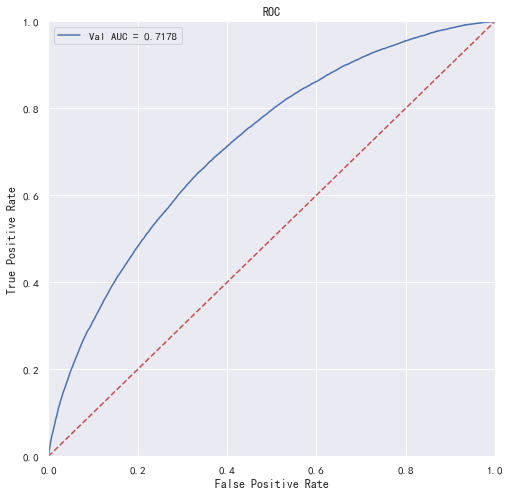

In [15]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [16]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
        
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.718983
[0.7189831988378461]
************************************ 2 ************************************


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	valid_0's auc: 0.715392
[0.7189831988378461, 0.7153915866572624]
************************************ 3 ************************************


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.719476
[0.7189831988378461, 0.7153915866572624, 0.7194764444838756]
************************************ 4 ************************************


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[109]	valid_0's auc: 0.718647
[0.7189831988378461, 0.7153915866572624, 0.7194764444838756, 0.7186469467349867]
************************************ 5 ************************************


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1077: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[LightGBM] [Warning] Unknown parameter: silent


C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\YX\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	valid_0's auc: 0.719435
[0.7189831988378461, 0.7153915866572624, 0.7194764444838756, 0.7186469467349867, 0.7194349846324942]
lgb_scotrainre_list:[0.7189831988378461, 0.7153915866572624, 0.7194764444838756, 0.7186469467349867, 0.7194349846324942]
lgb_score_mean:0.718386632269293
lgb_score_std:0.0015284427925435235


In [26]:
from sklearn.model_selection import cross_val_score

objectives = ['rank:map', 'reg:gamma', 'count:poisson', 'reg:tweedie', 'reg:squaredlogerror']

# 调objective
best_obj = dict()
for obj in objectives:
    model = lgb.LGBMRegressor(objective=obj)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_obj[obj] = score
    
# num_leaves
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_leaves[leaves] = score
    
# max_depth
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    """预测并计算roc的相关指标"""
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    best_depth[depth] = score

"""
可依次将模型的参数通过上面的方式进行调整优化，并且通过可视化观察在每一个最优参数下模型的得分情况
"""

NameError: name 'num_leaves' is not defined

In [28]:
"""通过网格搜索确定最优参数"""
from sklearn.model_selection import GridSearchCV

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))
